# Effects of data smoothing on parameter estimates



In [7]:
import jax.numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

import seaborn as sns

from jax import random, nn
from jax.experimental.ode import odeint

import numpyro as npyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.handlers import substitute, condition

from numpyro.distributions.transforms import AffineTransform, ExpTransform, ComposeTransform, IdentityTransform
from IPython.display import clear_output

npyro.enable_validation(True)
plt.style.use('seaborn-notebook')
%config InlineBackend.figure_format = 'retina'

In [75]:
def fun_I(x, aX, aI, g0):
    par1 = (g0 + aX)/(g0 - aI)
    par2 = (1 + aX)/aI
    
    return par1 * x + (par1 + par2) * (np.exp(np.log(1 - x) * aI/g0) - 1)

def static(N, data, obs=None):
    """
    :param int T: number of measured data points
    :param numpy.ndarray N: total population size for different categories with shape (K,)
    :param pandas.DataFrame data: collected data for X, I, D
    :param numpy.ndarray obs: 
    :param int K: number of categories
    """
    
    # infer the fraction of the total population that can be infected. With this we also assume a possible 
    # presence of social, biological or geographical barriers to the disease spreading.
    f = npyro.sample('f', dist.Exponential(1.))
    normalisation_factor = npyro.deterministic('nf', f * float(N))
    
    X_data = data['X']
    I_data = data['I']
    
    a_X = npyro.sample('a_X', dist.Gamma(20., 2.))
    a_I = npyro.sample('a_I', dist.Gamma(1000., 2.))
    
    g0 = npyro.sample('g0', dist.Gamma(3., 2.))
    
    I_pred = normalisation_factor * fun_I(X_data/normalisation_factor, a_X, a_I, g0)
    
    I_pred = npyro.deterministic('I', np.where(I_pred > 0, I_pred, .1))
        
    # measurement errors
    scale_I = npyro.sample("scale_I", dist.InverseGamma(2., 1.))
    
    with npyro.plate('obs', X_data.shape[0]):
        o_i = dist.Normal(0., 1.)
        o_i_1 = dist.TransformedDistribution(o_i, AffineTransform(np.log(I_pred), np.sqrt(scale_I)))
        npyro.sample("I_o", dist.TransformedDistribution(o_i_1, ExpTransform()), obs=obs)

In [25]:
# load information about the population in different regions
df_N = pd.read_csv('region_population.csv', index_col=0)

#########################                  
# Note that the region of Trentino-Alto Adige covers, regions of P.A. Bolzano and P.A. Trento which
# are included in the italy's. Hence we will combine them in one in the table bellow. 
#########################

# Load national data in Italy
df_national = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

# Load and format region specific data.
df_regional = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/'\
                            + 'master/dati-regioni/dpc-covid19-ita-regioni.csv')

df_regional = df_regional.set_index('data')

# Merge data for Trento and Bolzano into Trentino-Alto Adige
loc_bolz = df_regional.denominazione_regione == 'P.A. Bolzano'
loc_tren = df_regional.denominazione_regione == 'P.A. Trento'

df_ta = df_regional.loc[loc_bolz, 'totale_positivi':] + \
        df_regional.loc[loc_tren, 'totale_positivi':]

df_ta['denominazione_regione'] = 'Trentino-Alto Adige'

df_regional = df_regional.append(df_ta).reset_index()
df_regional = df_regional.drop(df_regional[df_regional.denominazione_regione == 'P.A. Bolzano'].index)
df_regional = df_regional.drop(df_regional[df_regional.denominazione_regione == 'P.A. Trento'].index)

In [26]:
df_national.rename(columns={'data': 'date', 
                            'casi_testati': 'total tests',
                            'totale_casi':'X',
                            'nuovi_positivi': 'I',
                            'deceduti': 'D'}, 
                      inplace=True)

df_national['dD'] = df_national['D'].diff()
df_national.loc[0, 'dD'] = df_national.loc[0, 'D']

df_regional.rename(columns={'data': 'date', 
                            'casi_testati': 'total tests', 
                            'denominazione_regione': 'region',
                            'totale_casi':'X',
                            'nuovi_positivi': 'I',
                            'deceduti': 'D'}, 
                     inplace=True)


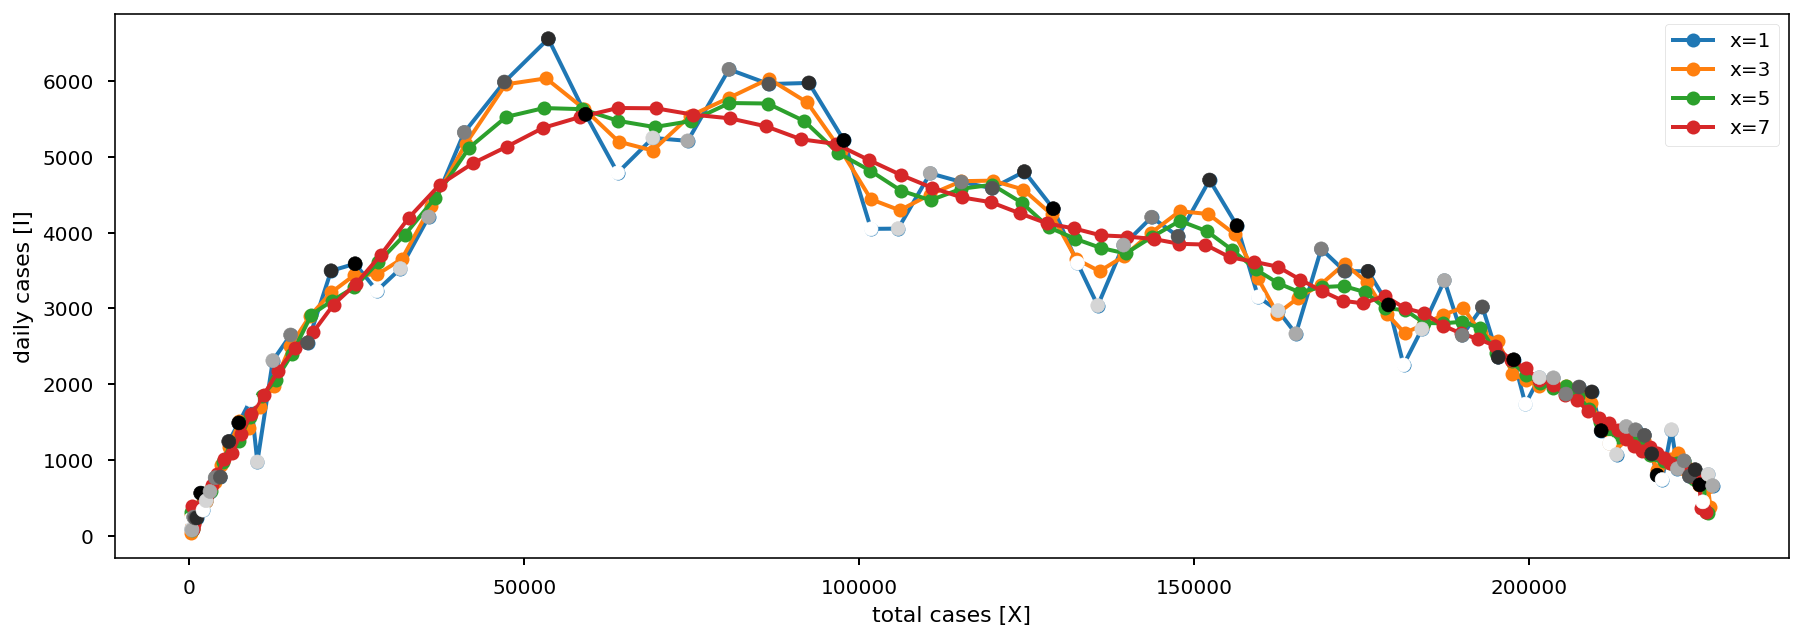

In [27]:
# plot data smoothed with x-days moving average

days = pd.to_datetime(df_national.date, infer_datetime_format=True).dt.dayofweek

fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for x in [1, 3, 5, 7]:
    X = df_national.X.rolling(window=x, min_periods=1, center=True).mean()
    I = np.diff(np.concatenate([np.zeros(1), X.values], -1), axis=-1)
    axes.plot(X, I, 'o-', label='x={}'.format(x), lw=2)

axes.scatter(df_national.X.values, df_national.I.values, c=days.values/6., cmap='gray_r', zorder=10)

axes.set_ylabel('daily cases [I]');
axes.set_xlabel('total cases [X]');
axes.legend();

fig.savefig('smoothing.png', dpi=300)

In [6]:
# fitting the static model
num_warmup = 1000
num_samples = 1000

N = df_N.Population.sum()
samples = {}
rng_key = random.PRNGKey(2441245)
for x in [1, 3, 5, 7]:
    I = np.array(df_national.I.rolling(window=x, center=True).mean().values)
    X = np.array(df_national.X.rolling(window=x, center=True).mean().values)
    if x > 1:
        l = (x - 1) // 2
        I = I[l:-l]
        X = X[l:-l]
    
    data = {'X': np.array(X),
            'I': np.array(I)}
    
    obs = np.where(np.nan_to_num(I) > 0, I, .1)

    nuts = NUTS(static, dense_mass=True, target_accept_prob=.9)
    mcmc = MCMC(nuts, num_warmup, num_samples)
    mcmc.run(rng_key, N=N, data=data, obs=obs)
    samples[x] = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:09<00:00, 202.00it/s, 7 steps of size 3.15e-01. acc. prob=0.94] 


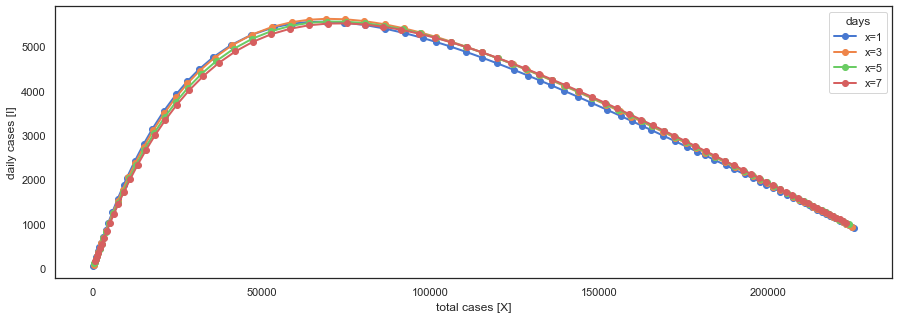

In [7]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

for x in samples:
    X = df_national.X.rolling(window=x, center=True).mean().values
    if x > 1:
        l = (x-1) // 2
        X =X[l:-l]
    
    axes.plot(X, samples[x]['I'].mean(0), 'o-', label='x={}'.format(x), lw=2)

axes.set_ylabel('daily cases [I]');
axes.set_xlabel('total cases [X]');
axes.legend(title='days');

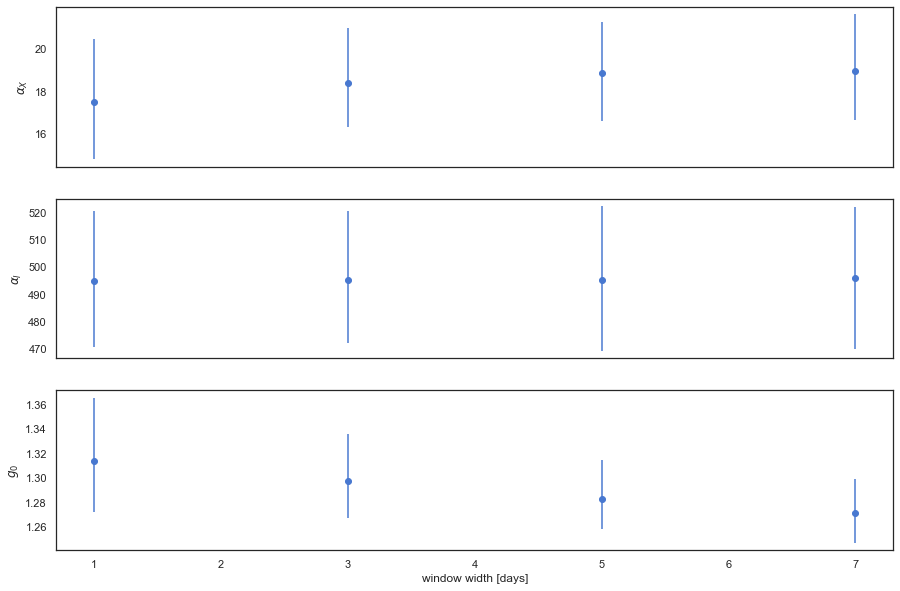

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for x in samples:
    a_x = np.percentile(samples[x]['a_X'], [5, 50, 95])
    yerr = np.array([a_x[1] - a_x[0], a_x[-1] - a_x[1]])[:, None]
    axes[0].errorbar(x, a_x[1], yerr=yerr, marker='o', color='b')
    axes[0].set_ylabel(r'$\alpha_X$')
    
    a_i = np.percentile(samples[x]['a_I'], [5, 50, 95])
    yerr = np.array([a_i[1] - a_i[0], a_i[-1] - a_i[1]])[:, None]
    axes[1].errorbar(x, a_i[1], yerr=yerr, marker='o', color='b')
    axes[1].set_ylabel(r'$\alpha_I$')
    
    g = np.percentile(samples[x]['g0'], [5, 50, 95])
    yerr = np.array([g[1] - g[0], g[-1] - g[1]])[:, None]
    axes[2].errorbar(x, g[1], yerr=yerr, marker='o', color='b')
    axes[2].set_ylabel(r'$g_0$')
    
axes[-1].set_xlabel('window width [days]');

# Data based smoothing

Instead of using moving averages for data smoothing we can adobt a more data driven appraoch. What we are interested in is knowing the delay between the onset of the disease and the date on which the deases is reportet. this infomration would allow us to smooth out data variability and distribute cases reported on day $t$ to all the previous days given the possible delays between the real onset of the disease and the confirmation.

To estimate the delay distribution we will use the detailed data of worldwide covid-19 cases reported at 

https://github.com/beoutbreakprepared/nCoV2019/

The procedure described here is copied from the notebooks availible at 

https://github.com/k-sys/covid-19


In [8]:
# Load the patient CSV downlaoded from https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz
patients = pd.read_csv(
    'latestdata.tar.gz',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

As a first step we will show the relationship between onset of symptoms and confirmation.


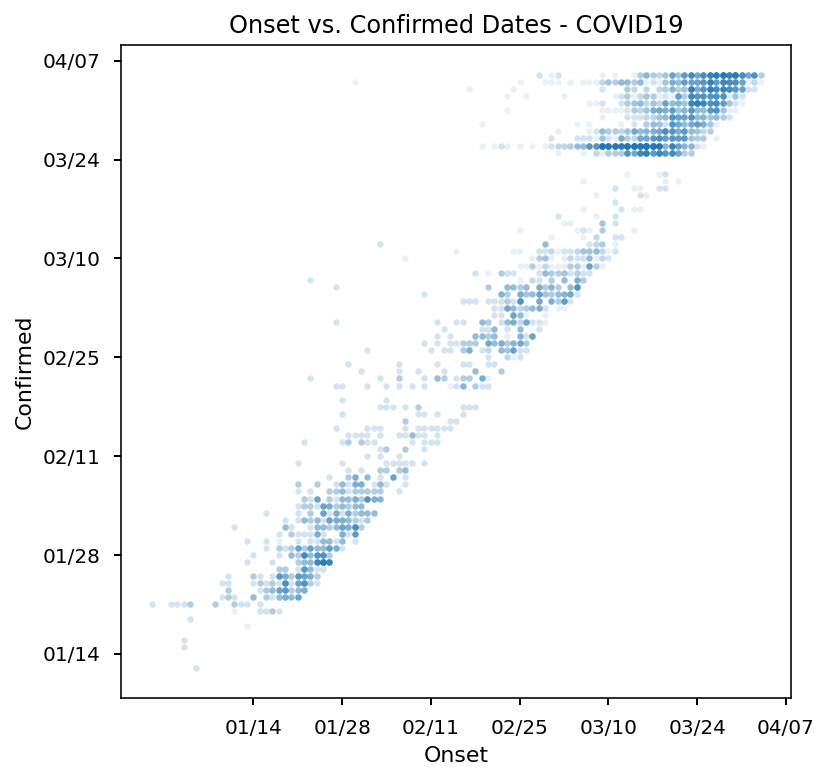

In [9]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

Next we will estimate the delay distribution

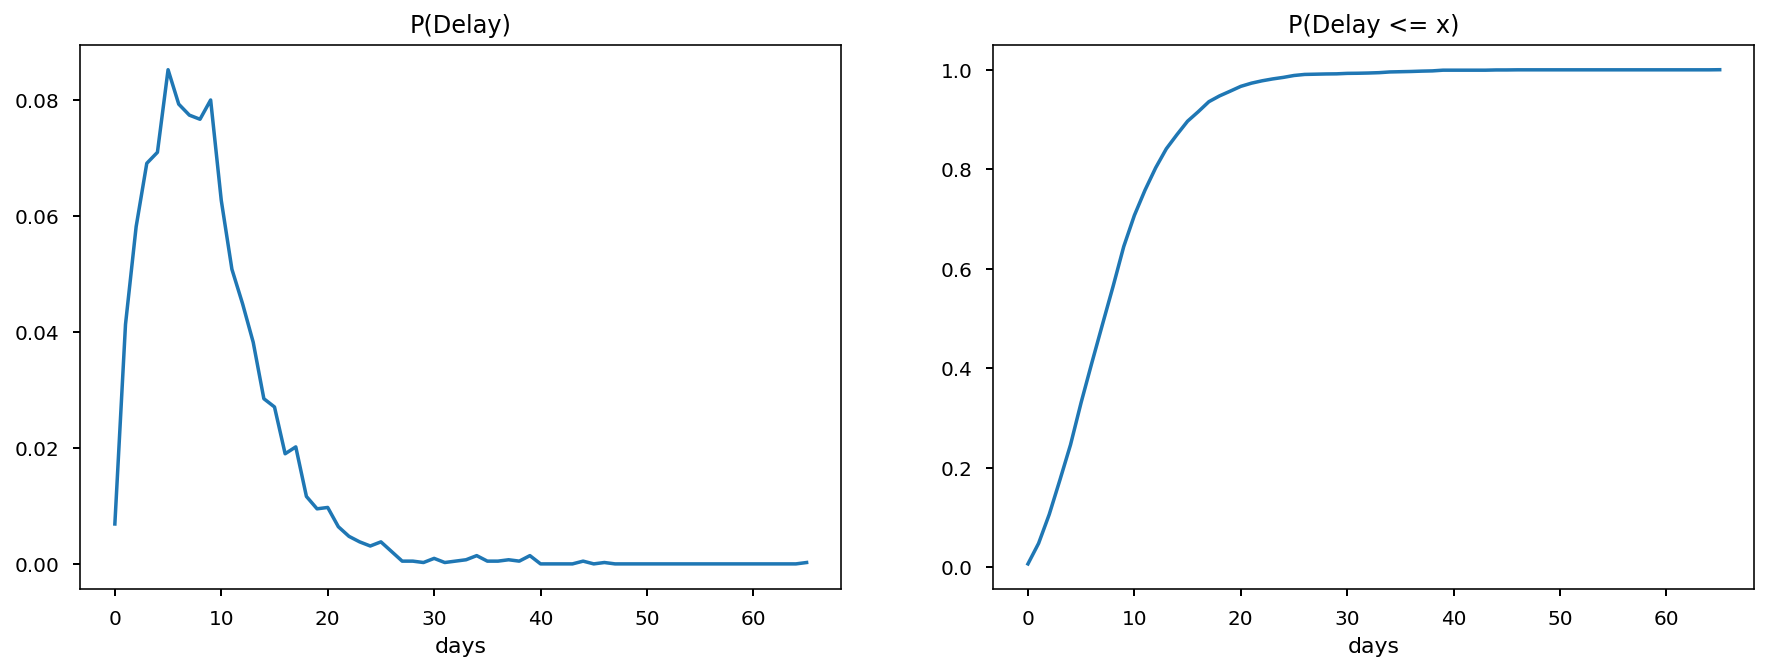

In [11]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(15,5))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [53]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset

df_national.date = pd.to_datetime(df_national.date, infer_datetime_format=True).dt.date

confirmed = df_national.set_index('date').I
onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day (the last day in the series).

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [56]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.onp.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.onp.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Lets take a look at all three series: confirmed, onset and onset adjusted for right censoring.

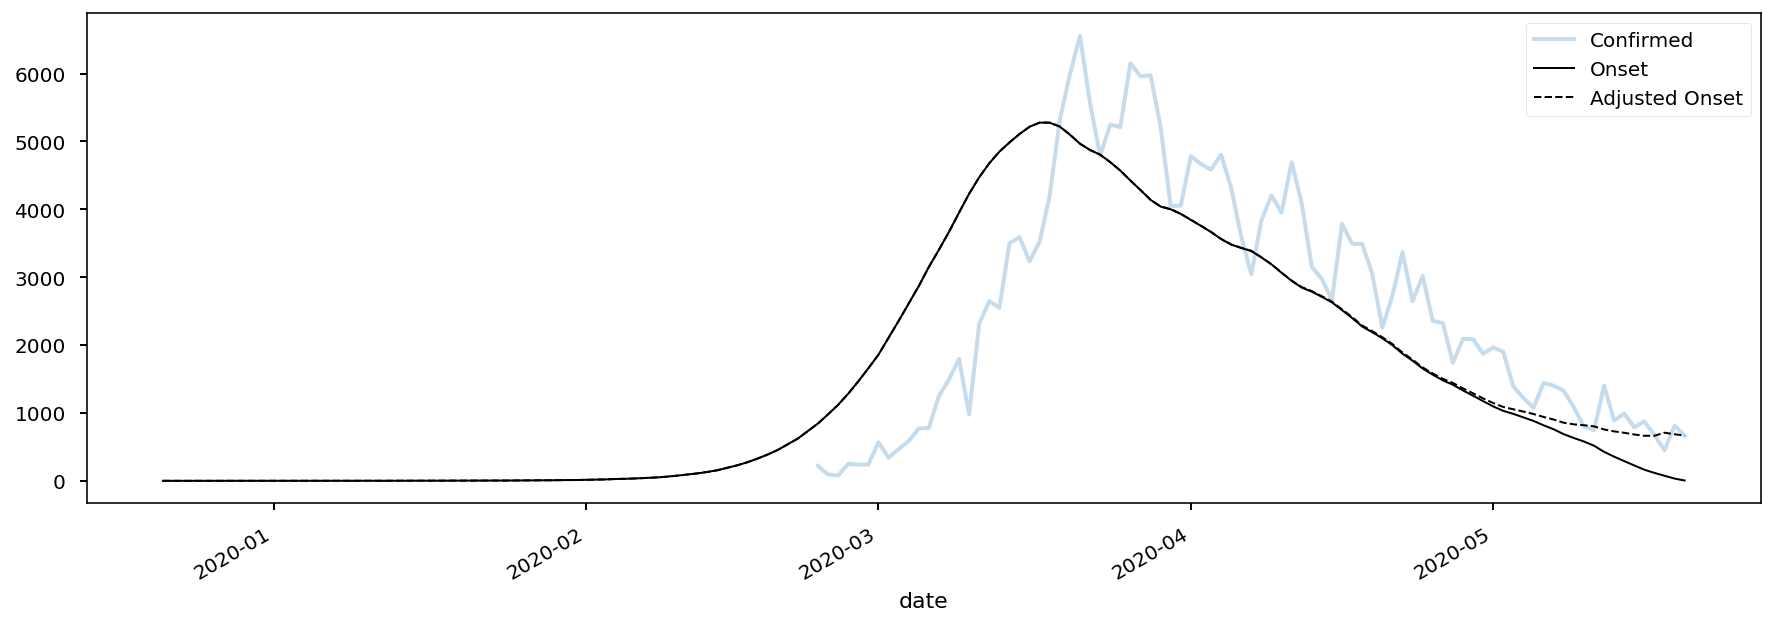

In [58]:
fig, ax = plt.subplots(figsize=(15,5))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    alpha=.25,
    lw=2)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let us show the X/I phase plot of adjusted data and compare it to the raw data and the 7 day centered moving average.

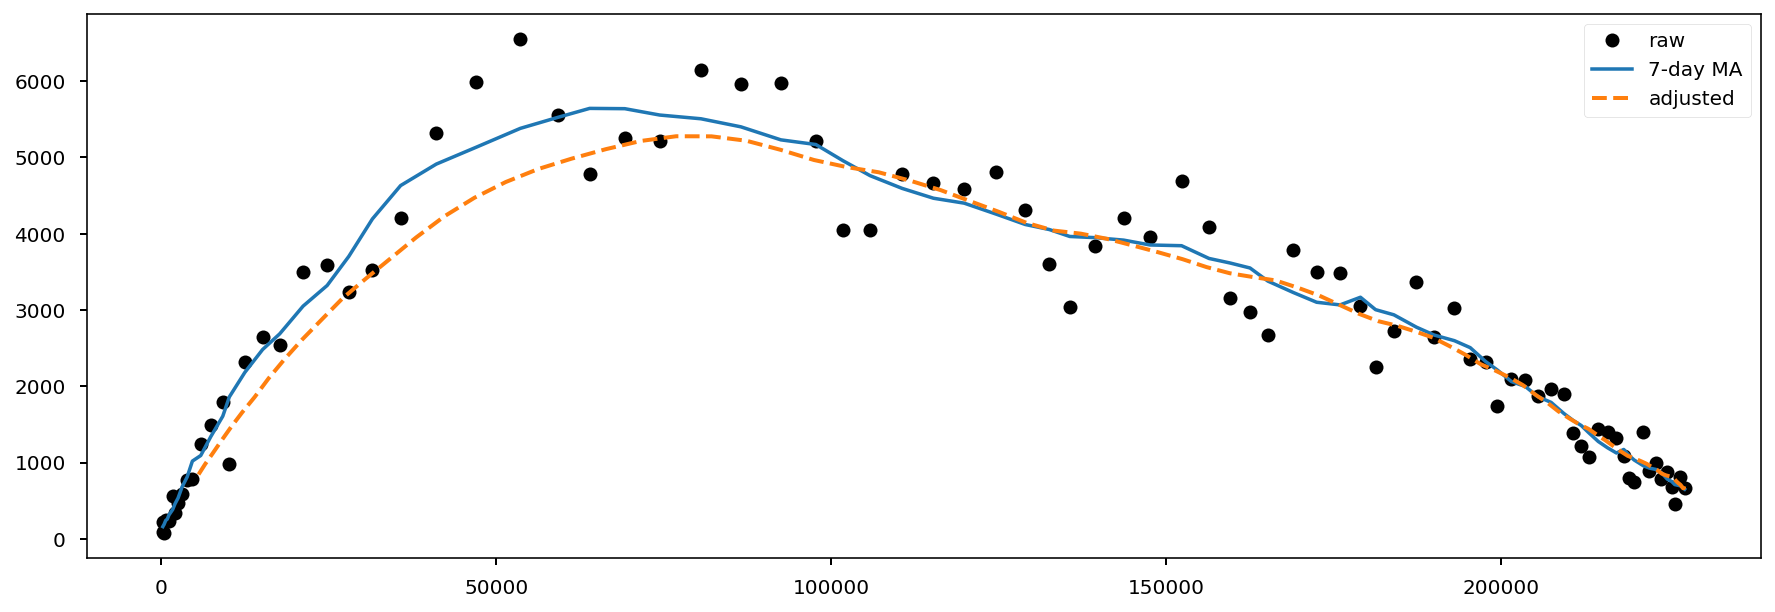

In [62]:
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(df_national.X, df_national.I, 'ko', label='raw')

plt.plot(df_national.X, df_national.I.rolling(center=True, window=7, min_periods=1).mean(), label='7-day MA')

n = len(df_national.X)
X = onset.cumsum().iloc[-n:]
I = adjusted.iloc[-n:]

plt.plot(X, I, '--', lw=2, label='adjusted')

ax.legend();

Finally, we will fit the adjusted time series to the controlled SIR model.

In [90]:
num_warmup = 1000
num_samples = 1000
N = df_N.Population.sum()

data = {'X': np.array(X.values),
        'I': np.array(I.values)}

obs = np.where(np.nan_to_num(data['I']) > 0, data['I'], .1)

nuts = NUTS(static, target_accept_prob=.95)
mcmc = MCMC(nuts, num_warmup, num_samples)
mcmc.run(random.PRNGKey(10101), N=N, data=data, obs=obs)
samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [00:11<00:00, 175.90it/s, 127 steps of size 1.63e-02. acc. prob=0.98]


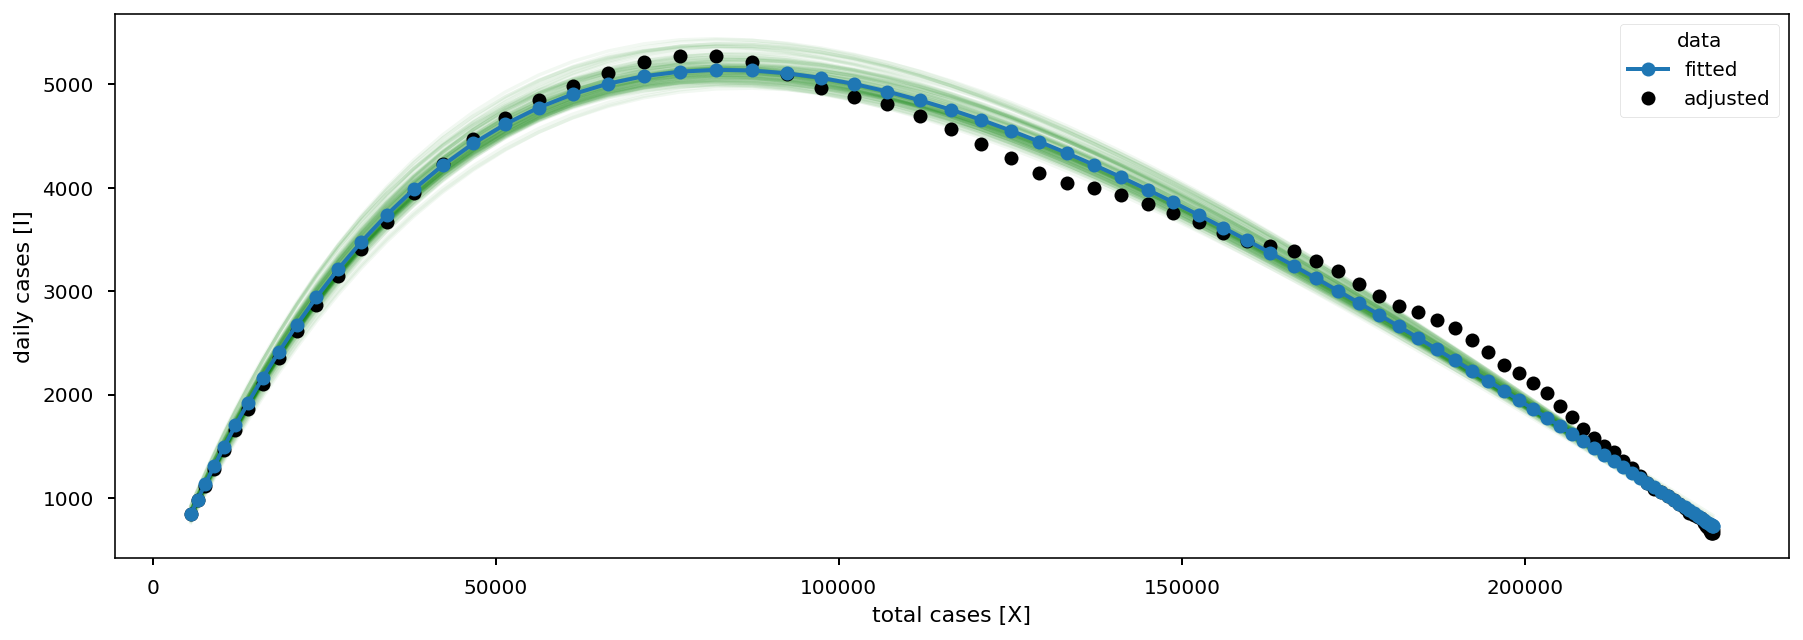

In [102]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

axes.plot(X, samples['I'].mean(0), 'o-', lw=2, zorder=10, label='fitted')
axes.plot(X, samples['I'][:100].T, 'g', alpha=.05)
axes.plot(X, I, 'ko', label='adjusted')

axes.set_ylabel('daily cases [I]');
axes.set_xlabel('total cases [X]');
axes.legend(title='data');

In [103]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       a_I    487.87     14.43    488.09    466.97    512.27    508.94      1.00
       a_X     22.16      1.54     22.09     19.55     24.68    332.50      1.00
         f      0.38      0.03      0.38      0.32      0.43    279.19      1.00
        g0      1.19      0.01      1.19      1.18      1.21    332.33      1.00
   scale_I      0.03      0.00      0.03      0.02      0.03    484.35      1.00

Number of divergences: 0


Given the parameter estimates from the smoothed data we can recover the time evolution of infection rate as 

$$ g(t) = \frac{g_0}{1 + \alpha_II(t) + \alpha_XX(t)}$$

as a next step we will compare the estimate of $g(t)$ obtained from the $X/I$ phase relation to a more direct model-free data driven approch proposed in https://github.com/k-sys/covid-19.

In [161]:
import pymc3 as pm
import theano.tensor as tt

class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=70):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=2, tune=2000, draws=500, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sigma=.025)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            tau = pm.Gamma('tau', alpha=4., beta=2.)
            r_t = pm.Deterministic('r_t', tau * theta + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self

In [ ]:
n = len(df_national.X)
mcmc_model = MCMCModel('Italy', onset, cumulative_p_delay, window=n+1).run()

Sampling 2 chains, 0 divergences:  60%|█████▉    | 2982/5000 [00:46<00:27, 73.10draws/s]

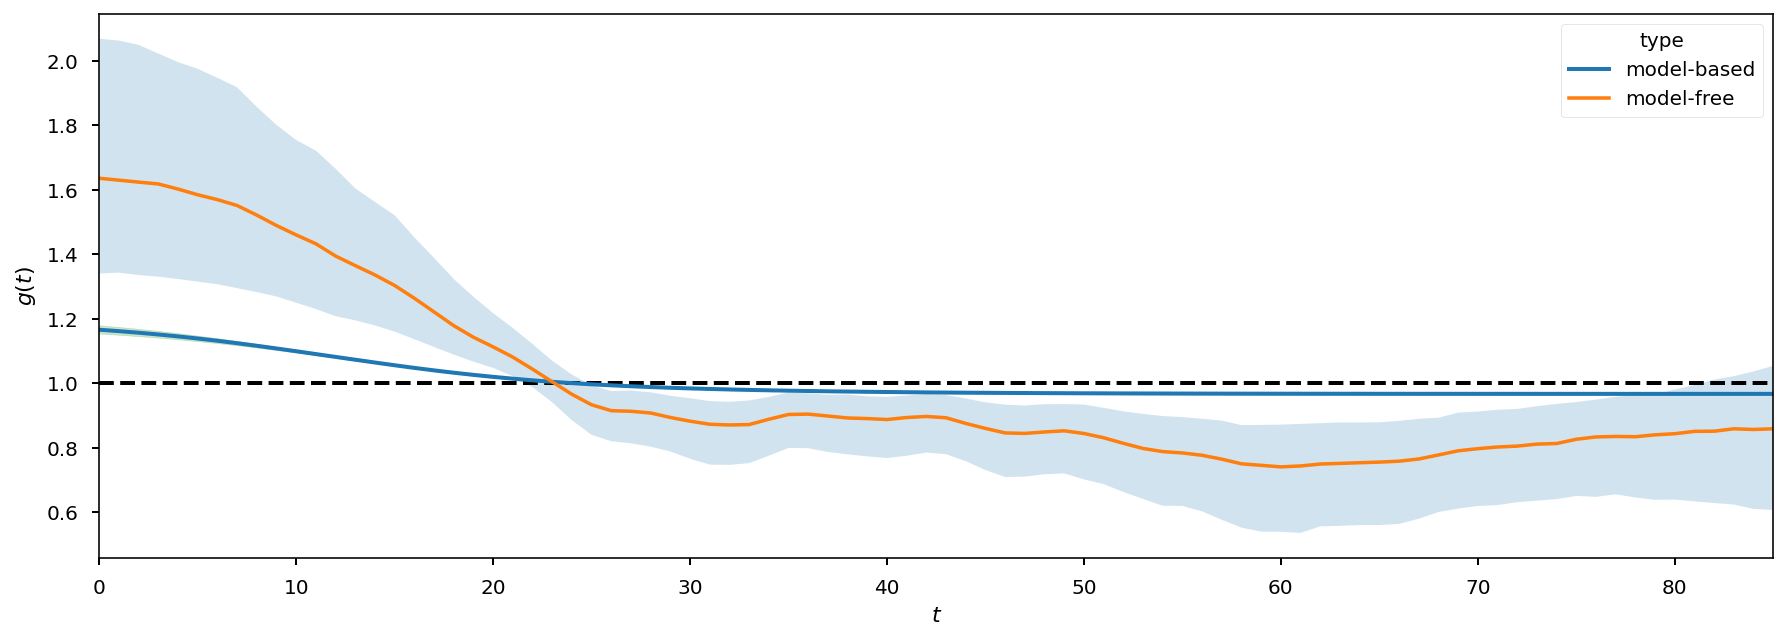

In [155]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))

I_norm = samples['I']/samples['nf'][:, None]
X_norm = X.values/samples['nf'][:, None]
g = samples['g0'][:,None]/(1 + samples['a_I'][:,None] * I_norm  + samples['a_X'][:, None] * X_norm)

g = np.onp.percentile(g, [5, 50, 95], axis=0)
axes.fill_between(range(n), g[0], y2=g[-1], color='g', alpha=.2)
axes.plot(g[1], lw=2, label='model-based');

r_t = np.onp.percentile(mcmc_model.trace['r_t'], [5, 50, 95], axis=0)
axes.plot(r_t[1], label='model-free')
axes.fill_between(range(n), r_t[0], y2=r_t[-1], alpha=.2)

axes.hlines(1, 0, 85, 'k', linestyle='--', lw=2);
axes.set_xlim([0, 85]);
axes.set_xlabel(r'$t$');
axes.set_ylabel(r'$g(t)$');
axes.legend(title='type');

Text(0, 0.5, 'count')

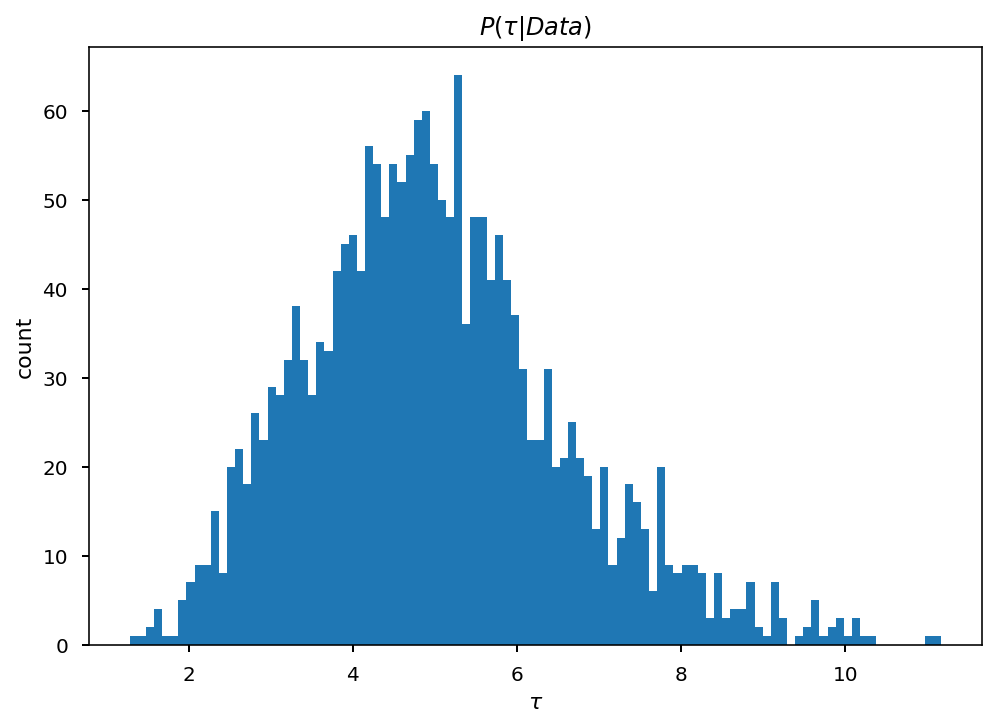

In [158]:
plt.hist(mcmc_model.trace['tau'], bins=100);
plt.title(r'$P(\tau|Data)$')
plt.xlabel(r'$\tau$')
plt.ylabel(r'count')